In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
# images_path = '/kaggle/input/itstep-exam-2/ship_images'
images_path = '/kaggle/input/airbus-ship-detection/train_v2'
csv_path = '/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv'

In [4]:
df = pd.read_csv(csv_path)
print("Розмір датафрейму:", df.shape)
print(df.head())


Розмір датафрейму: (231723, 2)
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Завантаження CSV з даними
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

# Перевірка наявних колонок
# print(df.head())

# Очищення даних від рядків з NaN у стовпці EncodedPixels
df_cleaned = df.dropna(subset=['EncodedPixels'])

# Підрахунок кількості кораблів на кожному зображенні
ship_counts = df_cleaned.groupby('ImageId').size()

# Виведення кількості кораблів для кожного зображення
print(ship_counts)


ImageId
000155de5.jpg    1
000194a2d.jpg    5
00021ddc3.jpg    9
0002756f7.jpg    2
00031f145.jpg    1
                ..
fff77c602.jpg    1
fff909871.jpg    1
fffcb6464.jpg    1
fffd924fb.jpg    2
fffdd2377.jpg    1
Length: 42556, dtype: int64


In [6]:
df_cleaned

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
231694,fff909871.jpg,441057 2 441825 4 442592 7 443360 9 444128 11 ...
231709,fffcb6464.jpg,222782 4 223550 10 224318 14 225086 14 225854 ...
231712,fffd924fb.jpg,110011 5 110779 5 111547 5 112315 5 113083 5 1...
231713,fffd924fb.jpg,198440 8 199208 8 199976 8 200744 8 201512 8 2...


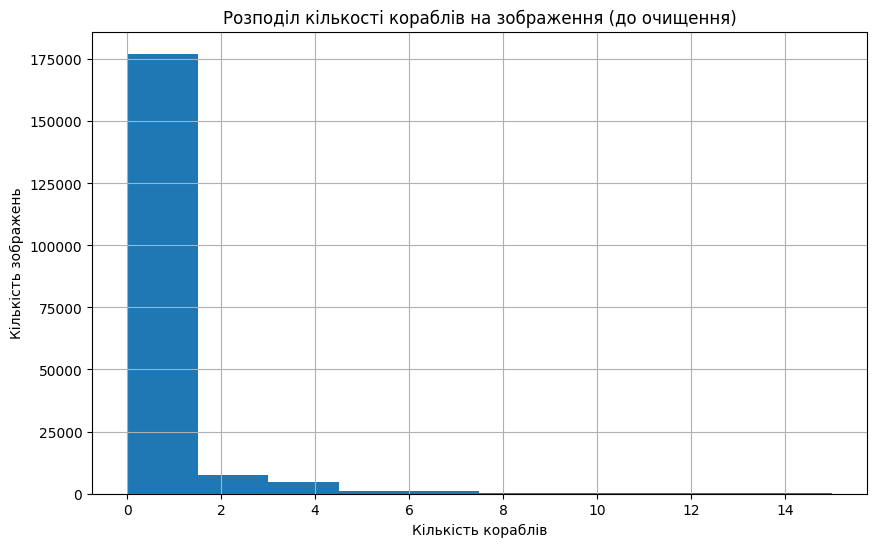

In [7]:
df['ships_count'] = df.groupby('ImageId')['EncodedPixels'].transform('count')

# Візуалізація розподілу кількості кораблів
ship_counts = df.groupby('ImageId')['ships_count'].max()
plt.figure(figsize=(10, 6))
ship_counts.hist(bins=10)
plt.title('Розподіл кількості кораблів на зображення (до очищення)')
plt.xlabel('Кількість кораблів')
plt.ylabel('Кількість зображень')
plt.show()

Кількість зображень з кораблями: 42556


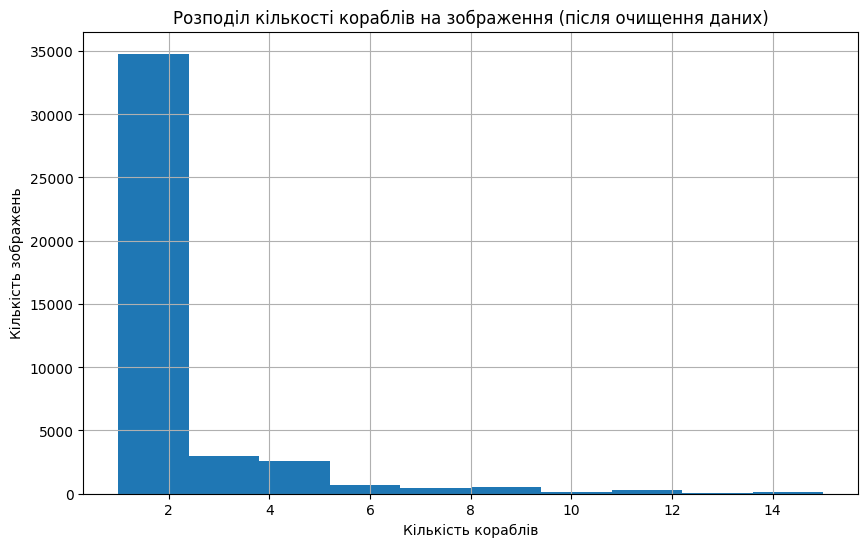

In [8]:
# Очищення даних від рядків з NaN у стовпці EncodedPixels
df_cleaned = df.dropna(subset=['EncodedPixels']).reset_index(drop=True)

# Кількість унікальних зображень з кораблями
unique_images_with_ships = df_cleaned['ImageId'].nunique()

# Підрахунок кількості кораблів на кожному зображенні (групуємо за ImageId)
ship_counts = df_cleaned.groupby('ImageId').size()

# Виведення кількості унікальних зображень з кораблями
print("Кількість зображень з кораблями:", unique_images_with_ships)

# Візуалізація розподілу кількості кораблів на кожному зображенні
plt.figure(figsize=(10, 6))
ship_counts.hist(bins=10)
plt.title('Розподіл кількості кораблів на зображення (після очищення даних)')
plt.xlabel('Кількість кораблів')
plt.ylabel('Кількість зображень')
plt.show()

In [9]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.1 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=6a42a40cb78adf032067b016b0c558ebf0ac2a65b6e2a54e05b6b1d943c06c5c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=bec4e7b571e217c212187b727adf29b6516c5cd45cdcdc9e2da338f5ddc91533
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

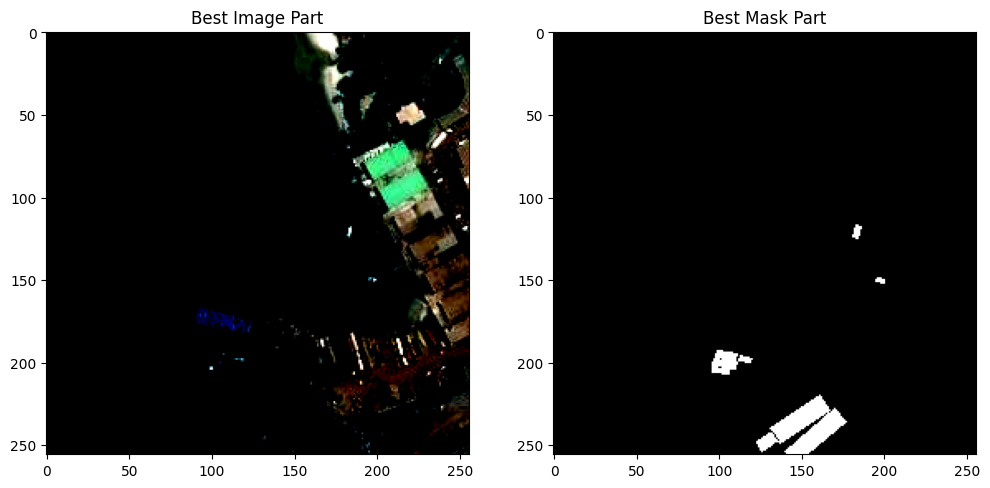

In [10]:
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from segmentation_models_pytorch.encoders import get_preprocessing_fn

class ShipDataset(Dataset):
    def __init__(self, images_path, df_cleaned, height=768, width=768, image_ids=None):
        self.images_path = images_path
        self.df_cleaned = df_cleaned
        self.height = height
        self.width = width
        self.image_ids = image_ids if image_ids is not None else df_cleaned['ImageId'].unique()
        
    def __len__(self):
        return len(self.image_ids)
    
    def rle_to_mask(self, rle, height, width):
        """
        Перетворює Run-Length Encoding в маску розміру height x width.
        :param rle: рядок, що містить Run-Length Encoding (пари start, length)
        :param height: висота маски
        :param width: ширина маски
        :return: маска у вигляді numpy масиву
        """
        mask = np.zeros(height * width, dtype=np.uint8)  # маска початково пуста
        rle_values = list(map(int, rle.split()))  # розділяємо рядок на числа
        
        for i in range(0, len(rle_values), 2):
            start = rle_values[i] - 1  # початковий піксель
            length = rle_values[i+1]  # довжина відрізка
            
            # Переводимо лінійний індекс в двовимірні координати (рядок, стовпець)
            start_row = start // width  # визначаємо рядок
            start_col = start % width   # визначаємо стовпець
            
            # Заповнюємо маску відповідними пікселями
            for j in range(length):
                row = (start + j) // width  # обчислюємо новий рядок
                col = (start + j) % width   # обчислюємо новий стовпець
                
                # Перевірка, чи не виходимо за межі маски
                if row < height and col < width:
                    mask[row * width + col] = 1  # встановлюємо піксель в 1

        return mask.reshape((height, width)).T  # Перетворюємо маску у формат 2D (height, width)

    def combine_masks(self, masks, height, width):
        """
        Об'єднує маски для кількох кораблів в одну
        """
        if masks:
            combined_mask = np.zeros((height, width), dtype=np.uint8)
            for mask in masks:
                combined_mask = np.maximum(combined_mask, mask)  # Об'єднуємо маски
        else:
            combined_mask = np.zeros((height, width), dtype=np.uint8)
        return combined_mask
    
    def split_image(self, image, mask, part_size=256):
        """
        Розрізає зображення та маску на 9 частин 256x256
        Вибирає ту частину, де найбільше пікселів кораблів
        """
        best_part_idx = None
        max_ship_pixels = 0

        # Розрізаємо зображення на 9 частин (3x3)
        image_parts = []
        mask_parts = []
        
        for i in range(3):  # 3 рядки
            for j in range(3):  # 3 стовпці
                start_row = i * part_size
                start_col = j * part_size
                end_row = start_row + part_size
                end_col = start_col + part_size

                image_part = image[start_row:end_row, start_col:end_col]
                mask_part = mask[start_row:end_row, start_col:end_col]

                image_parts.append(image_part)
                mask_parts.append(mask_part)

                # Підраховуємо кількість пікселів кораблів (1 в масці)
                ship_pixels = np.sum(mask_part)
                if ship_pixels > max_ship_pixels:
                    max_ship_pixels = ship_pixels
                    best_part_idx = len(image_parts) - 1  # Зберігаємо індекс найкращої частини

        # Повертаємо найкращу частину зображення та маски
        return image_parts[best_part_idx], mask_parts[best_part_idx]
    
    def __getitem__(self, idx):
        # Отримуємо ImageId
        image_id = self.image_ids[idx]
        
        # Завантажуємо зображення
        image_path = f"{self.images_path}/{image_id}"
        image = Image.open(image_path).convert('RGB')
        image = np.array(image.resize((self.width, self.height)))  # Змінюємо розмір зображення

        # Завантажуємо маски для поточного зображення
        masks = []
        encoded_pixels = self.df_cleaned[self.df_cleaned['ImageId'] == image_id]['EncodedPixels']
        
        for rle in encoded_pixels:
            mask = self.rle_to_mask(rle, self.height, self.width)
            masks.append(mask)
        
        # Об'єднуємо маски для всіх кораблів
        combined_mask = self.combine_masks(masks, self.height, self.width)
        
        # Ріжемо зображення та маску на 9 частин і вибираємо найкращу частину
        best_image_part, best_mask_part = self.split_image(image, combined_mask)

        preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
    
        # Застосовуємо preprocess_input до зображення
        best_image_part = preprocess_input(best_image_part)
        
        # Перетворення зображення в тензор
        transform = transforms.ToTensor()
        best_image_part = transform(best_image_part)
        
        # Виводимо кількість масок для поточного зображення
        # print(f"Number of ships (masks) in {image_id}: {len(masks)}")
        
        return best_image_part, best_mask_part

# Завантажуємо дані
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

# Очищення даних від рядків з NaN у стовпці EncodedPixels
df_cleaned = df.dropna(subset=['EncodedPixels'])

# Створюємо датасет
images_path = '/kaggle/input/airbus-ship-detection/train_v2'
dataset = ShipDataset(images_path=images_path, df_cleaned=df_cleaned)

# Виводимо зображення і маску для перевірки
image, mask = dataset[2]  # Отримуємо перший елемент датасету

# Виводимо зображення
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))  # перетворюємо з (C, H, W) в (H, W, C)
plt.title('Best Image Part')

# Виводимо маску
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Best Mask Part')
plt.show()


In [11]:
from sklearn.model_selection import train_test_split

# Розділення ImageId на тренувальну та тестову вибірки
# train_ids, test_ids = train_test_split(dataset.image_ids, test_size=0.2, random_state=42)
main_ids, small_ids = train_test_split(dataset.image_ids, test_size=0.1, random_state=42)

# Крок 2: Розділяємо 10% частину на тренувальну і тестову
train_ids, test_ids = train_test_split(small_ids, test_size=0.2, random_state=42)

# Створення DataFrame для тренувальних і тестових даних
train_df = df_cleaned[df_cleaned['ImageId'].isin(train_ids)]
test_df = df_cleaned[df_cleaned['ImageId'].isin(test_ids)]


In [12]:
print(f"Train size: {train_df.shape[0]}")  # Кількість рядків у тренувальному наборі
print(f"Test size: {test_df.shape[0]}") 

Train size: 6587
Test size: 1721


In [13]:
from torch.utils.data import DataLoader

# Тренувальний датасет
train_dataset = ShipDataset(image_ids=train_ids, df_cleaned=train_df, images_path=images_path)

# Тестовий датасет
test_dataset = ShipDataset(image_ids=test_ids, df_cleaned=test_df, images_path=images_path)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [14]:
len(train_loader), len(test_loader)

(27, 7)

In [15]:
import segmentation_models_pytorch as smp
import torch

# Створення моделі UNet
model = smp.Unet(
    encoder_name="resnet34",  # Основна архітектура
    encoder_weights="imagenet",  # Попередньо натреновані ваги
    in_channels=3,  # Кількість каналів на вході (RGB)
    classes=1,  # Кількість класів (1 для бінарної сегментації)
)

model


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 383MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [16]:
# Заморожуємо енкодер (встановлюємо requires_grad = False для його параметрів)
for param in model.encoder.parameters():
    param.requires_grad = False

# Перевіряємо, чи енкодер дійсно заморожений
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

encoder.conv1.weight: requires_grad=False
encoder.bn1.weight: requires_grad=False
encoder.bn1.bias: requires_grad=False
encoder.layer1.0.conv1.weight: requires_grad=False
encoder.layer1.0.bn1.weight: requires_grad=False
encoder.layer1.0.bn1.bias: requires_grad=False
encoder.layer1.0.conv2.weight: requires_grad=False
encoder.layer1.0.bn2.weight: requires_grad=False
encoder.layer1.0.bn2.bias: requires_grad=False
encoder.layer1.1.conv1.weight: requires_grad=False
encoder.layer1.1.bn1.weight: requires_grad=False
encoder.layer1.1.bn1.bias: requires_grad=False
encoder.layer1.1.conv2.weight: requires_grad=False
encoder.layer1.1.bn2.weight: requires_grad=False
encoder.layer1.1.bn2.bias: requires_grad=False
encoder.layer1.2.conv1.weight: requires_grad=False
encoder.layer1.2.bn1.weight: requires_grad=False
encoder.layer1.2.bn1.bias: requires_grad=False
encoder.layer1.2.conv2.weight: requires_grad=False
encoder.layer1.2.bn2.weight: requires_grad=False
encoder.layer1.2.bn2.bias: requires_grad=Fals

In [17]:
!pip install -q torchsummary

In [18]:
from torchsummary import summary

# Перенесення моделі на пристрій (CPU або GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Виведення summary моделі
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [19]:
# import torch
# import torch.nn.functional as F
# import segmentation_models_pytorch as smp

# class DiceBCELoss(torch.nn.Module):
#     def __init__(self, dice_weight=0.5, bce_weight=0.5):
#         super(DiceBCELoss, self).__init__()
#         self.dice_weight = dice_weight
#         self.bce_weight = bce_weight

#         # Ініціалізуємо DiceLoss від segmentation_models_pytorch
#         self.dice_loss = smp.losses.DiceLoss(mode="binary")
        
#     def forward(self, pred, target):
#         # BCELoss (бінарна крос-ентропія)
#         target = target.unsqueeze(1)
#         bce_loss = F.binary_cross_entropy_with_logits(pred, target)
        
#         # Dice Loss
#         dice_loss = self.dice_loss(pred, target)
        
#         # Зважена сума обох втрат
#         total_loss = self.bce_weight * bce_loss + self.dice_weight * dice_loss
#         return total_loss


In [20]:
!pip install kornia

In [21]:
# from kornia.losses import FocalLoss
# import torch
# import torch.nn.functional as F
# import segmentation_models_pytorch as smp

# class DiceFocalLoss(nn.Module):
#     def __init__(self, dice_weight=0.5, focal_weight=0.5, gamma=2.0, alpha=0.25):
#         super(DiceFocalLoss, self).__init__()
#         self.dice_weight = dice_weight
#         self.focal_weight = focal_weight
#         self.dice_loss = smp.losses.DiceLoss(mode="binary")
#         self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma, reduction="mean")

#     def forward(self, outputs, targets):
#         # Переконуємось, що мітки у правильному форматі для кожної втрати
#         dice_targets = targets.float()  # Для DiceLoss: float
#         focal_targets = targets.long()  # Для FocalLoss: int64

#         dice = self.dice_loss(outputs, dice_targets)
#         focal = self.focal_loss(outputs, focal_targets)
#         return self.dice_weight * dice + self.focal_weight * focal



In [22]:
from kornia.losses import FocalLoss
import torch
import torch.nn.functional as F
import segmentation_models_pytorch as smp

# class CombinedLoss(nn.Module):
#     def __init__(self, alpha=0.5, beta=0.5, focal_alpha=0.25, focal_gamma=2.0, reduction='mean'):
#         super().__init__()
#         self.alpha = alpha  # Вага для Dice Loss
#         self.beta = beta    # Вага для Focal Loss
#         self.dice_loss = smp.losses.DiceLoss(mode="binary")
#         self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, reduction=reduction)

#     def forward(self, pred, target):
#         # Якщо бінарна класифікація, видаляємо зайвий канал
#         if pred.shape[1] == 1:
#             pred = pred.squeeze(1)

#         dice = self.dice_loss(pred, target)
#         focal = self.focal_loss(pred, target)
#         return self.alpha * dice + self.beta * focal


In [23]:
# class CombinedLoss(nn.Module):
#     def __init__(self, alpha=0.5, beta=0.5, focal_alpha=0.25, focal_gamma=2.0, reduction='mean'):
#         super().__init__()
#         self.alpha = alpha  # Вага для Dice Loss
#         self.beta = beta    # Вага для Focal Loss
#         self.dice_loss = smp.losses.DiceLoss(mode="binary")
#         self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, reduction=reduction)

#     def forward(self, pred, target):
#         # Якщо бінарна класифікація, видаляємо зайвий канал
#         if pred.shape[1] == 1:
#             pred = pred.squeeze(1)

#         # Переконуємося, що розміри таргету відповідають передбаченням
#         if target.shape[2:] != pred.shape[2:]:
#             target = torch.nn.functional.interpolate(target.unsqueeze(1), size=pred.shape[2:], mode='nearest').squeeze(1)

#         # Переконуємося, що тип даних таргету правильний
#         target = target.float()  # DiceLoss і FocalLoss очікують float

#         # Перевіряємо, чи правильні розміри
        # assert pred.shape == target.shape, f"Pred shape {pred.shape} does not match target shape {target.shape}"

        # # Обчислення Dice та Focal лоссів
        # dice = self.dice_loss(pred, target)
        # focal = self.focal_loss(pred, target)

        # # Комбінований лосс
        # return self.alpha * dice + self.beta * focal




In [24]:
# loss_fn = DiceFocalLoss(dice_weight=0.5, focal_weight=0.5, gamma=2.0, alpha=0.25)

#loss_fn = CombinedLoss(alpha=0.5, beta=0.5, focal_alpha=0.25, focal_gamma=2.0)
loss_fn = smp.losses.DiceLoss(mode="binary")

# loss_fn = DiceBCELoss(dice_weight=0.5, bce_weight=0.5)

# ініціалізація оптимізатора
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [25]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)

# Підрахунок кількості параметрів
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Trainable parameters: 3151697
Non-trainable parameters: 21284672


In [26]:
# Втрата та оптимізатор
# loss_fn = smp.losses.DiceLoss(mode="binary")
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [27]:
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 15
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Тренувальний крок
    for images, masks in train_loader:
        # Переносимо на пристрій
        # images = images.to(device)
        # masks = masks.to(device)
        images = images.to(device).float()
        masks = masks.to(device).float()

        # Обчислення forward проходу
        optimizer.zero_grad()
        outputs = model(images)
        # outputs = outputs.squeeze(1)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss_avg = train_loss / len(train_loader)
    train_loss_history.append(train_loss_avg)

    torch.cuda.empty_cache()
    gc.collect()

    # Оцінка на валідаційних даних
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            # images = images.to(device)
            # masks = masks.to(device)
            images = images.to(device).float()
            masks = masks.to(device).float()

            outputs = model(images)
            # outputs = outputs.squeeze(1)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    val_loss_avg = val_loss / len(test_loader)
    val_loss_history.append(val_loss_avg)

    torch.cuda.empty_cache()
    gc.collect()

    # Виведення результатів кожного етапу
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss_avg:.4f}, "
          f"Validation Loss: {val_loss_avg:.4f}")

# # Зберігаємо модель після тренування
# torch.save(model.state_dict(), 'unet_model.pth')

# # Виведення часу тренування
# print(f"Training completed in: {time.time() - start_time:.2f} seconds")

Epoch [1/15], Train Loss: 0.8738, Validation Loss: 0.8428
Epoch [2/15], Train Loss: 0.7988, Validation Loss: 0.7548
Epoch [3/15], Train Loss: 0.6993, Validation Loss: 0.6515
Epoch [4/15], Train Loss: 0.5568, Validation Loss: 0.5112
Epoch [5/15], Train Loss: 0.4050, Validation Loss: 0.3780
Epoch [6/15], Train Loss: 0.2774, Validation Loss: 0.2859
Epoch [7/15], Train Loss: 0.2038, Validation Loss: 0.2481
Epoch [8/15], Train Loss: 0.1692, Validation Loss: 0.2139
Epoch [9/15], Train Loss: 0.1420, Validation Loss: 0.1984
Epoch [10/15], Train Loss: 0.1289, Validation Loss: 0.1973
Epoch [11/15], Train Loss: 0.1165, Validation Loss: 0.1945
Epoch [12/15], Train Loss: 0.1083, Validation Loss: 0.2103
Epoch [13/15], Train Loss: 0.1001, Validation Loss: 0.1763
Epoch [14/15], Train Loss: 0.0936, Validation Loss: 0.1806
Epoch [15/15], Train Loss: 0.0872, Validation Loss: 0.1741


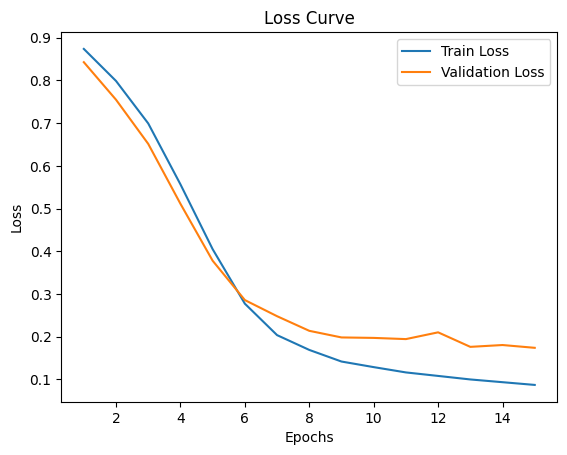

In [28]:
import matplotlib.pyplot as plt

num_epochs = 15
plt.plot(range(1, num_epochs+1), train_loss_history, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

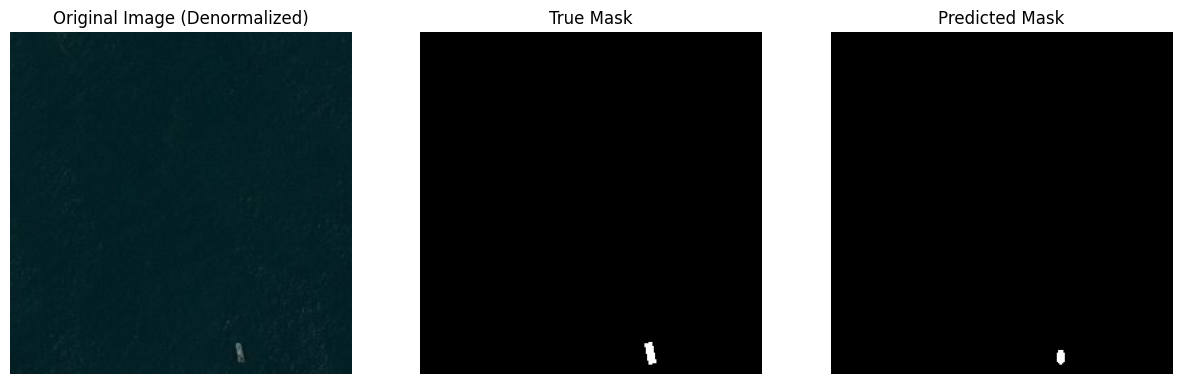

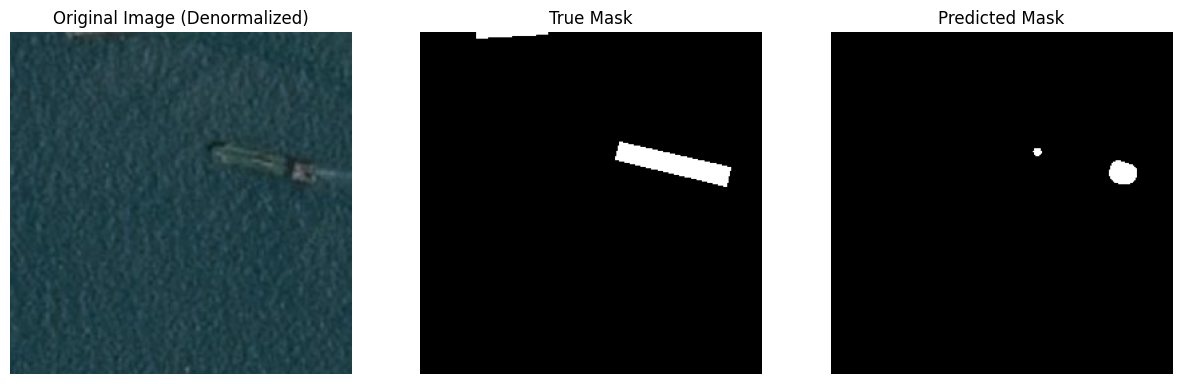

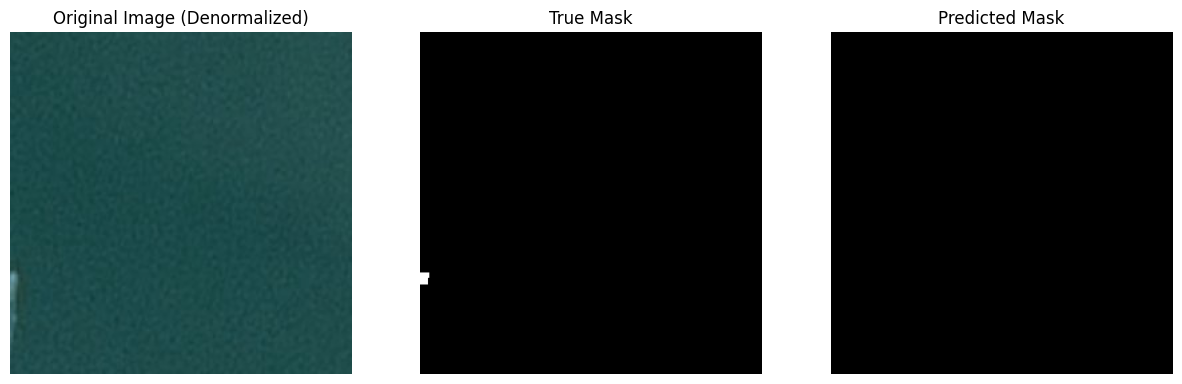

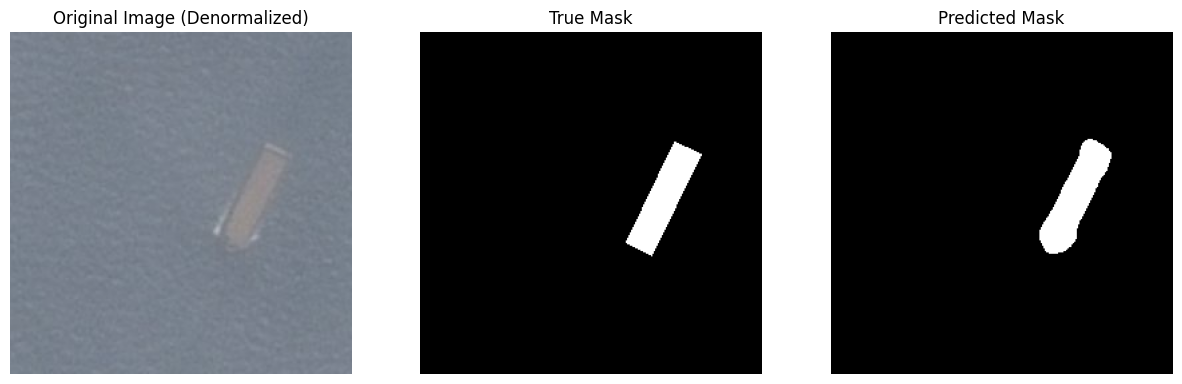

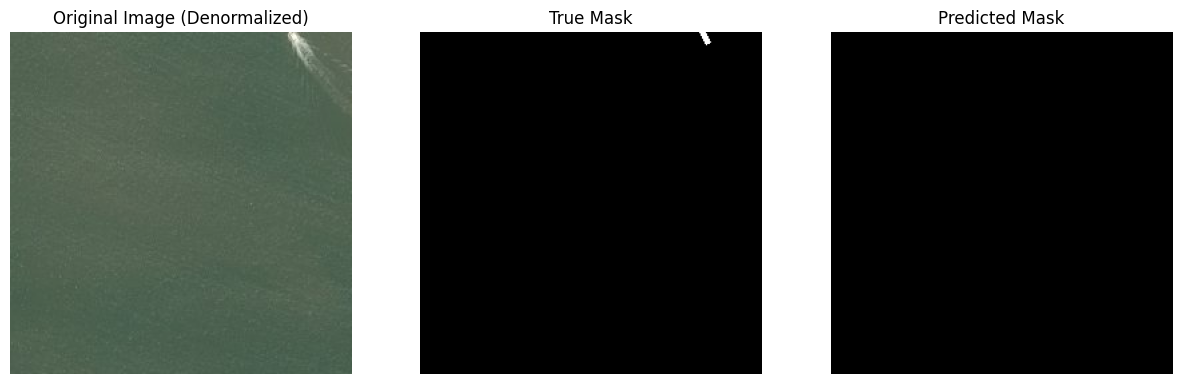

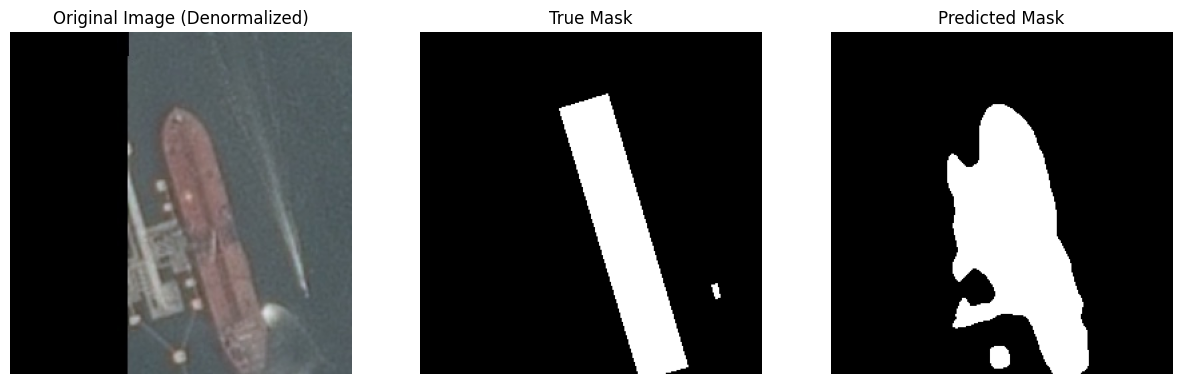

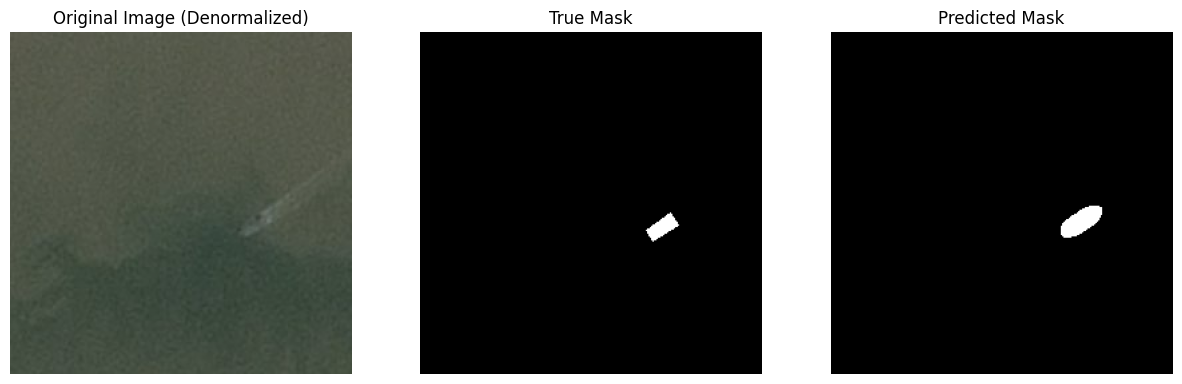

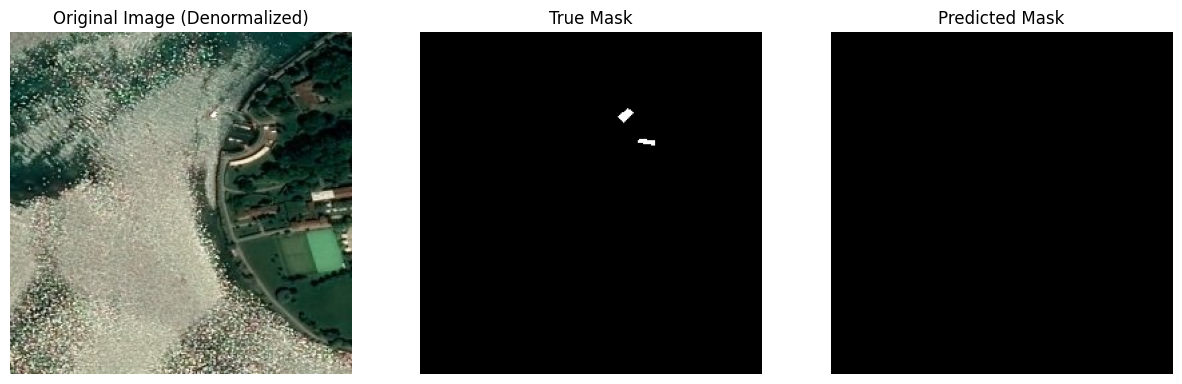

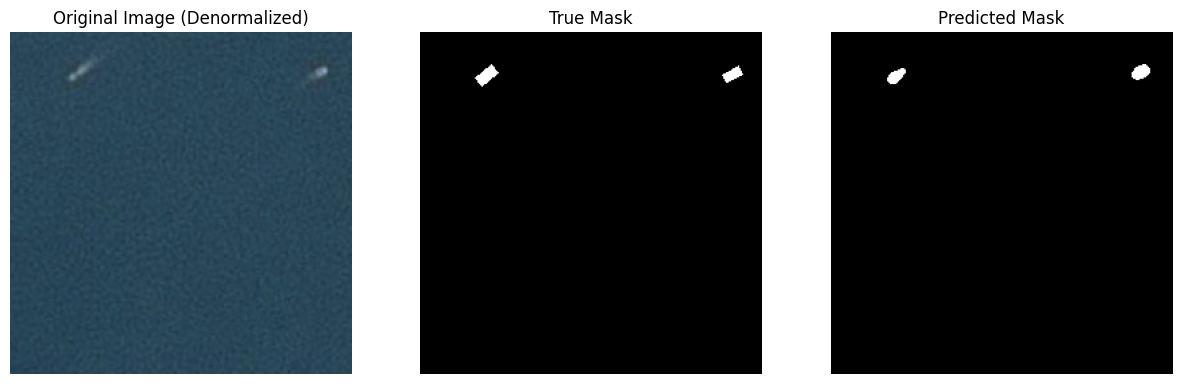

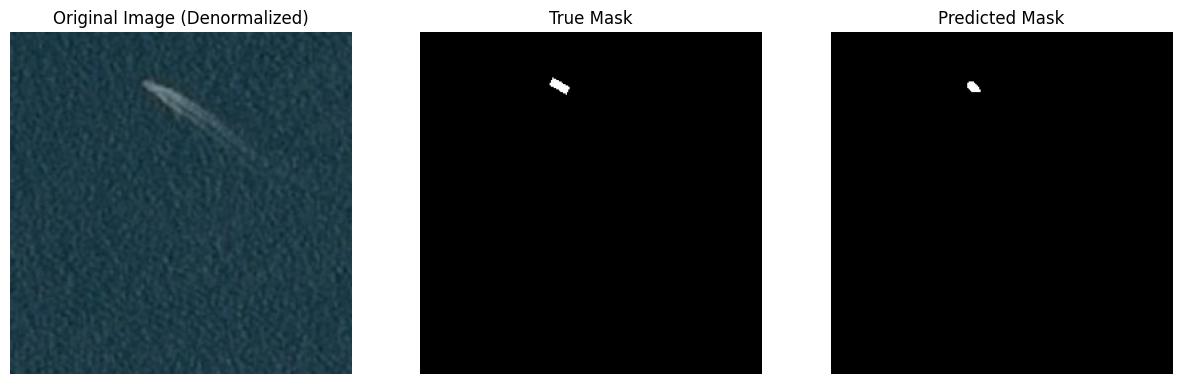

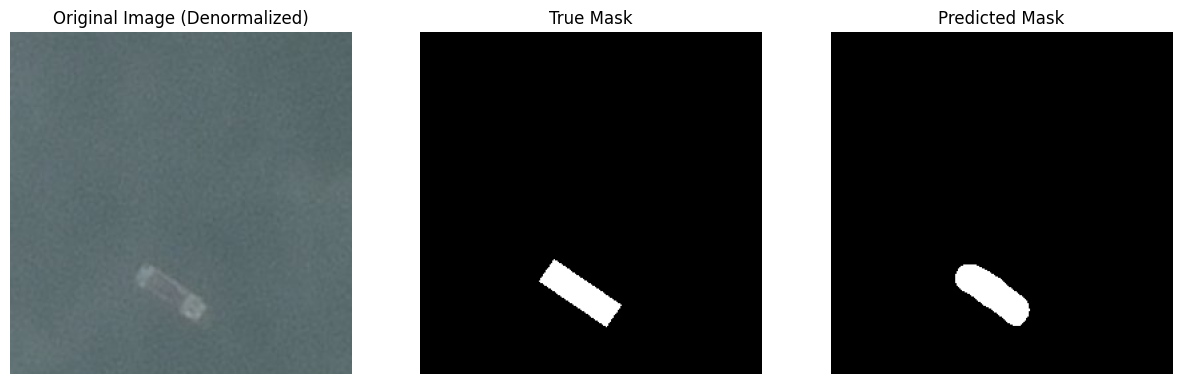

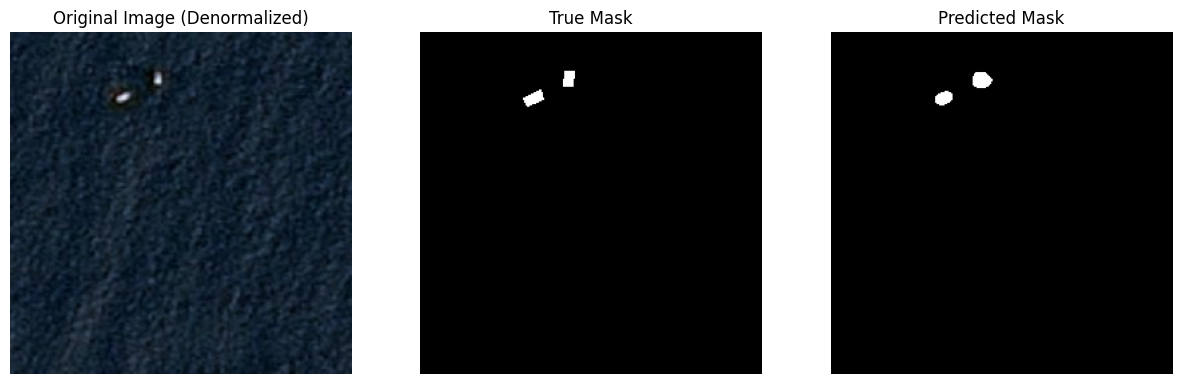

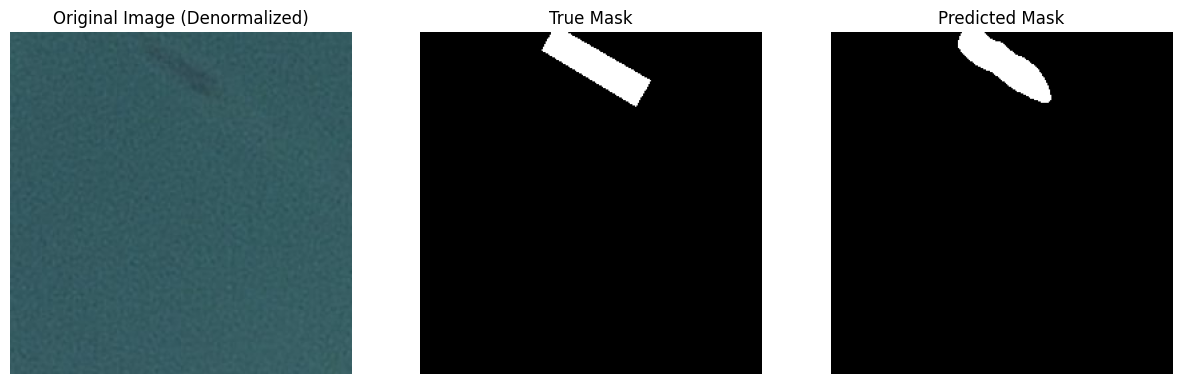

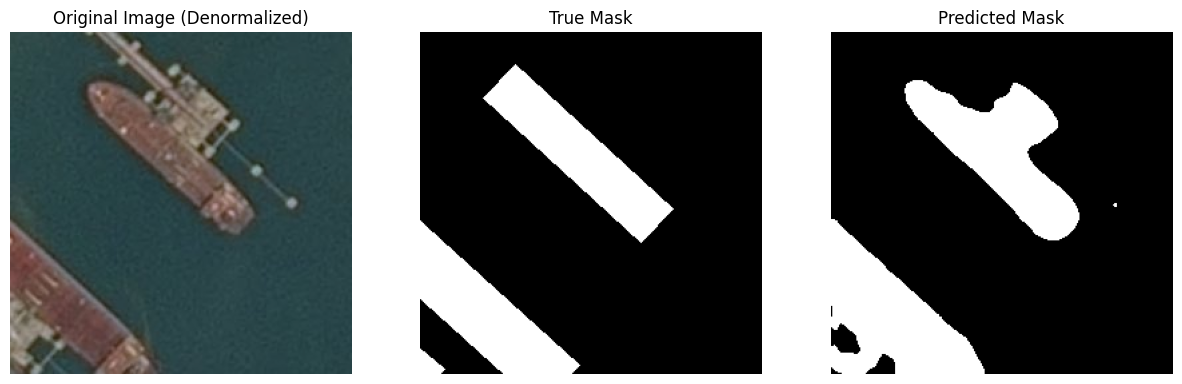

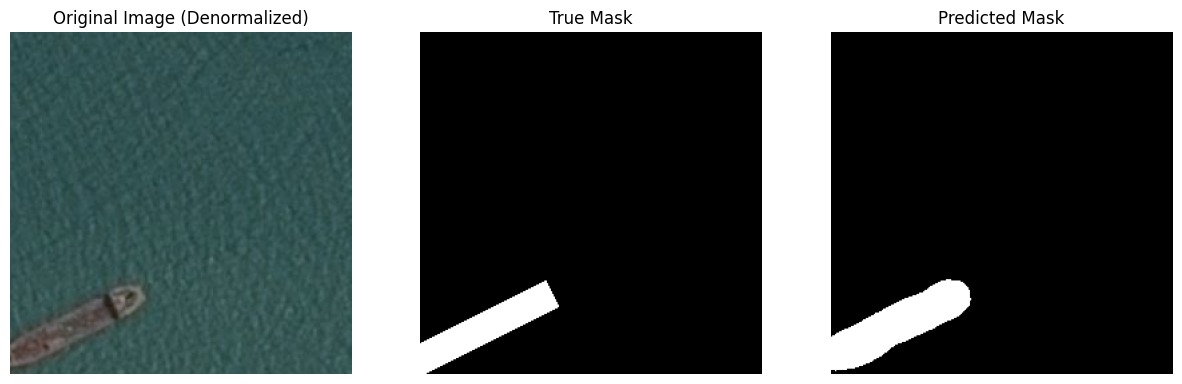

In [29]:
def denormalize_image(image):
    """
    Денормалізує зображення після `preprocess_input` на GPU або CPU.
    """
    mean = [0.485, 0.456, 0.406]  # Середні значення для ImageNet
    std = [0.229, 0.224, 0.225]   # Стандартні відхилення для ImageNet

    # Переносимо mean і std на той самий пристрій, де знаходяться зображення
    mean = torch.tensor(mean).reshape(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std).reshape(1, 3, 1, 1).to(image.device)

    # Денормалізація
    image = image * std + mean  # Зворотне масштабування
    return image


def visualize_results(model, test_loader, device, num_images=15):
    """
    Візуалізує результати моделі на тестовому датасеті, використовуючи денормалізацію для зображень.
    """
    model.eval()  # Переводимо модель в режим оцінки
    test_iter = iter(test_loader)  # Ітератор для тестових даних
    
    images_shown = 0  # Лічильник показаних зображень
    
    with torch.no_grad():  # Виключаємо градієнти
        while images_shown < num_images:
            images, true_masks = next(test_iter)
            images = images.to(device).float()  # Приводимо до float і переносимо на GPU
            true_masks = true_masks.to(device).float()  # Приводимо до float і переносимо на GPU
            
            # Передбачення масок
            pred_masks = model(images)  # Виклик моделі
            pred_masks = torch.sigmoid(pred_masks)  # Застосовуємо sigmoid для переводу в [0, 1]
            pred_masks = (pred_masks > 0.5).float()  # Бінаризуємо
            
            # Денормалізація зображень для візуалізації
            images_denormalized = denormalize_image(images)
            
            # Візуалізація
            for j in range(len(images)):
                if images_shown >= num_images:  # Перевірка на кількість виведених зображень
                    break
                
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                
                # Оригінальне зображення (денормалізоване)
                ax[0].imshow(images_denormalized[j].cpu().permute(1, 2, 0).clip(0, 1))  # Переносимо з GPU на CPU
                ax[0].set_title("Original Image (Denormalized)")
                ax[0].axis("off")
                
                # Реальна маска
                ax[1].imshow(true_masks[j].cpu().squeeze(), cmap="gray")  # Переносимо з GPU на CPU
                ax[1].set_title("True Mask")
                ax[1].axis("off")
                
                # Передбачена маска
                ax[2].imshow(pred_masks[j].cpu().squeeze(), cmap="gray")  # Переносимо з GPU на CPU
                ax[2].set_title("Predicted Mask")
                ax[2].axis("off")
                
                images_shown += 1  # Збільшуємо лічильник
                plt.show()

# Визначте пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Перенесіть модель на пристрій
model.to(device)

# Виклик функції
visualize_results(model, test_loader, device, num_images=15)


In [30]:
# def visualize_results(model, test_loader, device, num_images=1):
#     """
#     Візуалізує результати моделі на тестовому датасеті, використовуючи денормалізацію для зображень.
#     """
#     model.eval()  # Переводимо модель в режим оцінки
#     test_iter = iter(test_loader)  # Ітератор для тестових даних

#     with torch.no_grad():  # Виключаємо градієнти
#         for i in range(num_images):
#             images, true_masks = next(test_iter)
#             images = images.to(device).float()  # Приводимо до float і переносимо на GPU
#             true_masks = true_masks.to(device).float()  # Приводимо до float і переносимо на GPU
            
#             # Передбачення масок
#             pred_masks = model(images)  # Виклик моделі
#             pred_masks = torch.sigmoid(pred_masks)  # Застосовуємо sigmoid для переводу в [0, 1]
#             pred_masks = (pred_masks > 0.5).float()  # Бінаризуємо
            
#             # Денормалізація зображень для візуалізації
#             images_denormalized = denormalize_image(images)

#             # Візуалізація
#             for j in range(len(images)):
#                 fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                
#                 # Оригінальне зображення (денормалізоване)
#                 ax[0].imshow(images_denormalized[j].cpu().permute(1, 2, 0).clip(0, 1))  # Переносимо з GPU на CPU
#                 ax[0].set_title("Original Image (Denormalized)")
#                 ax[0].axis("off")
                
#                 # Реальна маска
#                 ax[1].imshow(true_masks[j].cpu().squeeze(), cmap="gray")  # Переносимо з GPU на CPU
#                 ax[1].set_title("True Mask")
#                 ax[1].axis("off")
                
#                 # Передбачена маска
#                 ax[2].imshow(pred_masks[j].cpu().squeeze(), cmap="gray")  # Переносимо з GPU на CPU
#                 ax[2].set_title("Predicted Mask")
#                 ax[2].axis("off")
                
#                 plt.show()

# # Визначте пристрій
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Перенесіть модель на пристрій
# model.to(device)

# # Виклик функції
# visualize_results(model, test_loader, device, num_images=1)